In [79]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [80]:
%matplotlib inline

from sessions import selected_009266, selected_008229, selected_009265, selected_57
from imports import *
from scipy import stats
from scipy import signal
from matplotlib.lines import Line2D
from sklearn import decomposition
from population import unit_activity_matrix
from spiketrain import get_shuffled
from events import get_event_periods
from psth import staple_pulsetrain, staple_spike_times
from neurosuite import get_unit_names_sorted

import itertools

In [81]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [82]:
def get_asterisks(pval):
    if pval > 0.05:
        return 'n.s.'
    elif pval > 0.01:
        return '*'
    elif pval > 0.001:
        return '**'
    elif pval > 0.0001:
        return '***'
    else:
        return '****'

In [83]:
def get_conf_intervals(data):
    conf_low  = np.zeros(data.shape[1])
    conf_high = np.zeros(data.shape[1])
    for i, col in enumerate(data.T):
        conf_low[i]  = np.percentile(col, 5)
        conf_high[i] = np.percentile(col, 95)
        
    return conf_low, conf_high

In [84]:
source = '/home/sobolev/nevermind_ag-grothe/AG_Pecka/data/processed/'
source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'
rep_path = '/home/sobolev/nevermind/Andrey/analysis/manuscripts/'

nMAP_electrodes = {
    '009265': [1, 2],
    '009266': [1, 2],
    '57': [1],
    '60': [1, 2],
}

# manuscript session
# '009266_hippoSIT_2023-04-18_10-10-37'

all_selected = selected_009266 + selected_009265 + selected_57
selected = all_selected

## PCA for no stimulus

In [85]:
vars_real, vars_shuf = [], []

for i, session in enumerate(selected):
    animal   = session.split('_')[0]
    s_path   = os.path.join(source, animal, session)
    coh_file = os.path.join(s_path, 'analysis', 'coherence.h5')
    
    if not os.path.exists(coh_file):
        continue

    with h5py.File(coh_file, 'r') as f:
        vars_real.append(np.array(f['var_real_SIL']))
        vars_shuf.append(np.array(f['var_shuf_SIL']))
        
vars_real = np.array(vars_real)
vars_shuf = np.array(vars_shuf)
len(vars_real)

41

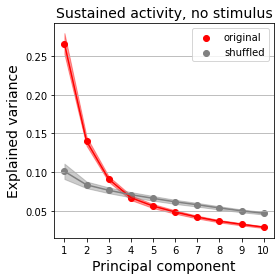

In [95]:
# 10th scale - 500 of 10ms bins binning - 5 seconds
idx_win_size = 10
comp_count = 10
var_sil_real = vars_real[:, idx_win_size, :]
var_sil_shuf = vars_shuf[:, idx_win_size, :]

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

x_vals = (np.arange(comp_count) + 1).astype(np.int32)
conf_low_real, conf_high_real = get_conf_intervals(var_sil_real)
conf_low_shuf, conf_high_shuf = get_conf_intervals(var_sil_shuf)
verm = var_sil_real.mean(axis=0)
vesm = var_sil_shuf.mean(axis=0)
sem_real = stats.sem(var_sil_real)
sem_shuf = stats.sem(var_sil_shuf)

ax.plot(x_vals, var_sil_real.mean(axis=0), color='red')
ax.plot(x_vals, var_sil_shuf.mean(axis=0), color='grey')
ax.scatter(x_vals, var_sil_real.mean(axis=0), color='red', label='original')
ax.scatter(x_vals, var_sil_shuf.mean(axis=0), color='grey', label='shuffled')

# sems
ax.fill_between(x_vals, verm - sem_real, verm + sem_real, color='red', alpha=0.4)
ax.fill_between(x_vals, vesm - sem_shuf, vesm + sem_shuf, color='grey', alpha=0.4)

# 5 - 95 conf intervals
#ax.fill_between(x_vals, conf_low_real, conf_high_real, color='red', alpha=0.4)
#ax.fill_between(x_vals, conf_low_shuf, conf_high_shuf, color='grey', alpha=0.4)
#ax.set_ylim(0, 0.15)

ax.grid(axis='y')
ax.set_xticks(x_vals)
ax.set_xticklabels(x_vals, fontsize=10)
ax.set_xlabel('Principal component', fontsize=14)
ax.set_ylabel('Explained variance', fontsize=14)
ax.set_title('Sustained activity, no stimulus', fontsize=14)
ax.legend()

fig.tight_layout()
fig.savefig(os.path.join(rep_path, 'SU_exp_var_no_stimulus.png'), dpi=300)

## Variance relative to shuffle depending on the bin size

In [87]:
max_comp = 10
diffs = np.zeros([vars_real.shape[0], vars_real.shape[1]])  # sessions, win_sizes
for i in range(vars_real.shape[0]):  # across sessions
    for j in range(vars_real.shape[1]):
        diffs[i][j] = (vars_real[i][j][:max_comp] - vars_shuf[i][j][:max_comp]).sum()

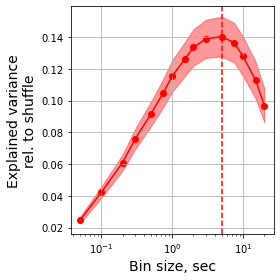

In [88]:
win_sizes = [5, 10, 20, 30, 50, 75, 100, 150, 200, 300, 500, 750, 1000, 1500, 2000]  # in number of bins of bin_size

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

#x_vals = np.arange(len(win_sizes))+1  # linear
x_vals = np.array(win_sizes) * 0.01  # almost logarithmic
conf_l, conf_h = get_conf_intervals(diffs)
sem_real = stats.sem(diffs)
verm = diffs.mean(axis=0)

ax.plot(x_vals, verm, color='red')
ax.scatter(x_vals, verm, color='red', label='original')
#ax.fill_between(x_vals, conf_l, conf_h, color='red', alpha=0.4)
ax.fill_between(x_vals, verm - sem_real, verm + sem_real, color='red', alpha=0.4)
ax.axvline(x_vals[np.argmax(diffs.mean(axis=0))], color='red', ls='--')
ax.set_xscale('log')
ax.grid()
ax.set_xlabel('Bin size, sec', fontsize=14)
ax.set_ylabel('Explained variance\nrel. to shuffle', fontsize=14)
#ax.set_xticks(x_vals)
#ax.set_xticklabels(np.array(win_sizes) * 0.01)

fig.tight_layout()
fig.savefig(os.path.join(rep_path, 'SU_exp_var_binning.png'), dpi=300)

## Pairwise correlations - no stimulus

In [89]:
# 10th scale - 500 of 10ms bins binning - 5 seconds
#  8th scale - 200 of 10ms bins binning - 2 seconds
idx_win_size = 8

corrs_real, corrs_shuf = [], []

for i, session in enumerate(selected):
    animal   = session.split('_')[0]
    s_path   = os.path.join(source, animal, session)
    coh_file = os.path.join(s_path, 'analysis', 'coherence.h5')
    
    if not os.path.exists(coh_file):
        continue

    with h5py.File(coh_file, 'r') as f:
        corrs_real.append(np.array(f['corrs_real_SIL'][idx_win_size]))
        corrs_shuf.append(np.array(f['corrs_shuf_SIL'][idx_win_size]))

corrs_real_flat = np.concatenate([x for x in corrs_real])
corrs_shuf_flat = np.concatenate([x for x in corrs_shuf])

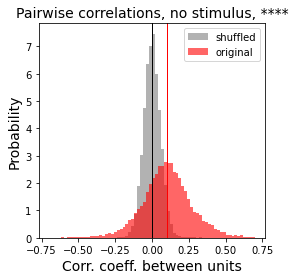

In [96]:
bins_nc = np.linspace(-0.7, 0.7, 71)
#bins_nc = np.linspace(-1, 1, 101)

corrs_real = corrs_real_flat
corrs_shuf = corrs_shuf_flat

_, pval = stats.mannwhitneyu(corrs_shuf, corrs_real)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.hist(corrs_shuf, bins=bins_nc, density=True, alpha=0.6, color='grey', label='shuffled')
ax.hist(corrs_real, bins=bins_nc, density=True, alpha=0.6, color='red', label='original')
ax.axvline(corrs_shuf.mean(), color='black', lw=1)
ax.axvline(corrs_real.mean(), color='red', lw=1)
#ax.set_xlim(-0.15, 0.15)
#ax.set_xlim(-0.5, 0.5)
ax.legend()
ax.set_xlabel("Corr. coeff. between units", fontsize=14)
ax.set_ylabel("Probability", fontsize=14)
ax.set_title('Pairwise correlations, no stimulus, %s' % get_asterisks(pval), fontsize=14)

fig.tight_layout()
fig.savefig(os.path.join(rep_path, 'SU_pairwise_corrs.png'), dpi=300)

## Sustained activity - component comparison between BGR and SIL

In [91]:
comps_SIL, comps_BGR = [], []

for i, session in enumerate(selected):
    animal   = session.split('_')[0]
    s_path   = os.path.join(source, animal, session)
    coh_file = os.path.join(s_path, 'analysis', 'coherence.h5')
    
    if not os.path.exists(coh_file):
        continue

    with h5py.File(coh_file, 'r') as f:
        comps_SIL.append(np.array(f['comp_real_SIL'][idx_win_size, 0, :]))
        comps_BGR.append(np.array(f['comp_real_BGR'][idx_win_size, 0, :]))

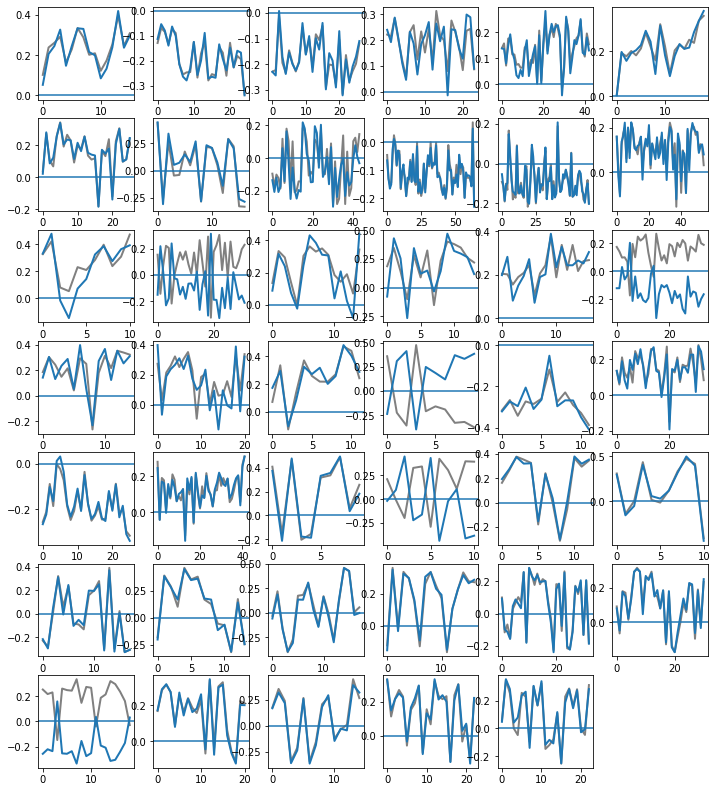

In [92]:
cols = 6
rows = int(np.ceil(len(comps_SIL)/cols))
fig = plt.figure(figsize=(2*cols, 2*rows))

for i in range(len(comps_SIL)):
    ax = fig.add_subplot(rows, cols, i+1)
    ax.plot(comps_SIL[i], color='gray', lw=2)
    ax.plot(comps_BGR[i], color='tab:blue', lw=2)
    ax.axhline(0)

In [93]:
# component correlations
corr_coeffs = np.zeros(len(comps_SIL))

for i in range(len(comps_SIL)):
    corr_coeffs[i] = stats.pearsonr(comps_SIL[i], comps_BGR[i])[0]

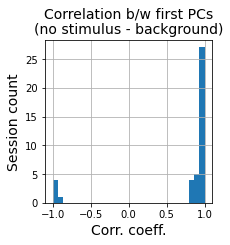

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

bins = np.linspace(-1, 1, 30)
ax.hist(corr_coeffs, bins=bins)
ax.set_xlabel('Corr. coeff.', fontsize=14)
ax.set_ylabel('Session count', fontsize=14)
ax.set_title('Correlation b/w first PCs\n(no stimulus - background)', fontsize=14)
ax.grid()

fig.savefig(os.path.join(rep_path, 'SU_first_PCs_corrs.png'), dpi=300)

## Sessions: unit count

In [130]:
unit_count = 10

# sessions with > 10 units
for i, session in enumerate(selected):
    animal    = session.split('_')[0]
    s_path    = os.path.join(source, animal, session)
    unit_file = os.path.join(s_path, 'units.h5')
    electrodes = nMAP_electrodes[animal]

    with h5py.File(unit_file, 'r') as f:
        unit_names = get_unit_names_sorted([name for name in f if int(name.split('-')[0]) in electrodes])

    if len(unit_names) >= unit_count:
        print('%s: %d' % (session, len(unit_names)))
    else:
        print('%s: %d NOT ENOUGH' % (session, len(unit_names)))

009266_hippoSIT_2023-04-17_17-04-17: 16
009266_hippoSIT_2023-04-18_10-10-37: 25
009266_hippoSIT_2023-04-18_17-03-10: 27
009266_hippoSIT_2023-04-19_10-33-51: 24
009266_hippoSIT_2023-04-20_08-57-39: 4 NOT ENOUGH
009266_hippoSIT_2023-04-21_08-43-00: 4 NOT ENOUGH
009266_hippoSIT_2023-04-21_13-12-31: 5 NOT ENOUGH
009266_hippoSIT_2023-04-24_10-08-11: 43
009266_hippoSIT_2023-04-24_16-56-55: 19
009266_hippoSIT_2023-04-26_08-20-17: 26
009266_hippoSIT_2023-05-02_12-22-14: 17
009266_hippoSIT_2023-05-04_19-47-15: 44
009266_hippoSIT_2023-05-22_09-27-22: 65
009266_hippoSIT_2023-05-23_09-18-05: 65
009266_hippoSIT_2023-05-25_15-55-57: 55
009266_hippoSIT_2023-06-14_08-21-23: 11
009266_hippoSIT_2023-06-19_08-58-35: 32
009265_hippoSIT_2023-02-28_13-16-10: 15
009265_hippoSIT_2023-02-28_20-45-04: 14
009265_hippoSIT_2023-03-01_10-46-12: 5 NOT ENOUGH
009265_hippoSIT_2023-03-02_09-32-54: 4 NOT ENOUGH
009265_hippoSIT_2023-03-02_16-27-42: 17
009265_hippoSIT_2023-03-02_20-11-35: 34
009265_hippoSIT_2023-03-03_09-

In [78]:
((np.arange(5)+1)*13)-1

array([12, 25, 38, 51, 64])

## PLAYGROUND

In [13]:
def smooth_gaussian(data, k_width):
    kernel  = signal.gaussian(k_width, std=(k_width) / 7.2)
    return np.convolve(data, kernel, 'same') / kernel.sum()

In [14]:
def smooth_rectangular(data, width_in_bins):
    kernel = np.ones(width_in_bins)
    return np.convolve(data, kernel, 'same') / kernel.sum()

In [40]:
session = '009266_hippoSIT_2023-04-17_17-04-17'
#session = '009266_hippoSIT_2023-04-19_10-33-51'
animal  = session.split('_')[0]
s_path   = os.path.join(source, animal, session)
meta_file = os.path.join(s_path, 'meta.h5')
unit_file = os.path.join(s_path, 'units.h5')

electrodes = nMAP_electrodes[animal]  # electrodes in A1

# reading data
with h5py.File(meta_file, 'r') as f:
    sound_events = np.array(f['processed']['sound_events'])
    tl = np.array(f['processed']['timeline'])
    tgt_mx = np.array(f['processed']['target_matrix'])
    cfg = json.loads(f['processed'].attrs['parameters'])
    trials = np.array(f['processed']['trial_idxs'])

spike_times = {}
with h5py.File(unit_file, 'r') as f:
    unit_names = [x for x in f if int(x.split('-')[0]) in electrodes]
with h5py.File(unit_file, 'r') as f:
    for unit_name in unit_names:
        spike_times[unit_name]  = np.array(f[unit_name]['spike_times'])

# -------------- Compute population responses -----------------------

bin_size = 0.01
ev_su_lag = 0.12

ev_bin_count = int(ev_su_lag/bin_size)
ev_times_beg = sound_events[:, 0]
ev_times_end = ev_times_beg + ev_su_lag
ev_periods = np.vstack([ev_times_beg, ev_times_end]).T

su_bin_count = int((cfg['sound']['latency'] - ev_su_lag)/bin_size)
su_times_beg = sound_events[:, 0] + ev_su_lag
su_times_end = su_times_beg + cfg['sound']['latency'] - ev_su_lag
su_periods = np.vstack([su_times_beg, su_times_end]).T

ev_bins = np.arange(0, np.diff(ev_periods, axis=1).sum(), bin_size)  # ignore last uneven bin
ev_unit_mx = np.zeros([len(unit_names), len(ev_bins)-1])
su_bins = np.arange(0, np.diff(su_periods, axis=1).sum(), bin_size)  # ignore last uneven bin
su_unit_mx = np.zeros([len(unit_names), len(su_bins)-1])

for k, unit_name in enumerate(unit_names):
    s_times = spike_times[unit_name]

    # shrink all spikes as if there is no other periods.
    ev_strain = staple_spike_times(s_times, ev_periods, mode='sequence')  # result is in periods!
    ev_strain = np.array([item for sublist in ev_strain for item in sublist])  # flatten to one array
    ev_unit_mx[k] = np.histogram(ev_strain, bins=ev_bins)[0]

    su_strain = staple_spike_times(s_times, su_periods, mode='sequence')  # result is in periods!
    su_strain = np.array([item for sublist in su_strain for item in sublist])  # flatten to one array
    su_unit_mx[k] = np.histogram(su_strain, bins=su_bins)[0]
    

# for sustained - z-score, smooth and take 1st PC

# 1. Sum BEFORE: 
su_unit_mx_events = np.zeros([len(unit_names), len(sound_events)])
for i in range(len(unit_names)):
    for j in range(len(sound_events)):
        su_unit_mx_events[i][j] = su_unit_mx[i][j*13:(j+1)*13].mean()
    
for j in range(len(unit_names)):
    su_unit_mx_events[j] = stats.zscore(su_unit_mx_events[j])
    
# 2. Sum AFTER: doesn't work
for j in range(len(unit_names)):
    su_unit_mx[j] = smooth_rectangular(su_unit_mx[j], 200)
    su_unit_mx[j] = stats.zscore(su_unit_mx[j])
    

su_pca = decomposition.PCA(n_components=10)
su_X   = su_pca.fit_transform(su_unit_mx.T)
su_resp = su_X[:, 0]  # PC1 scores. bin_size resolution
su_resp = su_resp.reshape([int(su_resp.shape[0]/su_bin_count), su_bin_count]).mean(axis=1)  # sound events resolution

su_resp = smooth_gaussian(su_resp, 15)


(0.9333257157298639, 0.0)

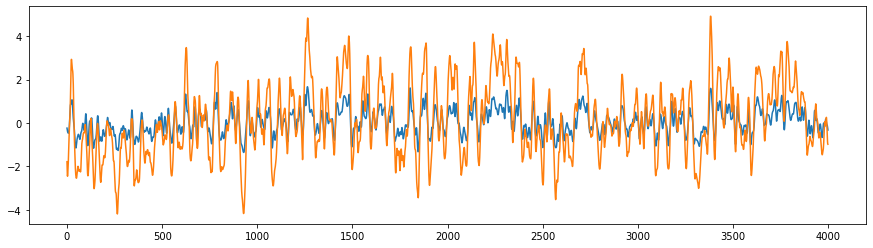

In [42]:
d_l, d_r = 0, 4000
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.plot(response_manifold[d_l:d_r, 1])
ax.plot(su_resp[d_l:d_r])

#ax.plot(ev_resp_mx.sum(axis=1)[:d_max]/10)
#ax.plot(evoked_resp_sm[:d_max])

#ax.vlines(tgt_mx[tgt_mx[:, 4] == 1][:, 1], -5, 5)
#ax.vlines(trials[:, 1], -5, 5)
#ax.set_xlim(d_l, d_r)

stats.pearsonr(response_manifold[:, 1], su_resp)

In [41]:
stats.pearsonr(response_manifold[:, 1], su_resp)

(0.9333257157298639, 0.0)

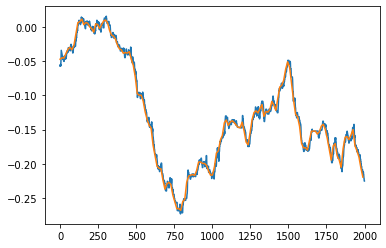

In [435]:
su_resp_low_res = sustained_resp.reshape([int(124787/13), 13]).mean(axis=1)

x_vals_h = np.arange(2000)
x_vals_l = np.arange(2000)[::13]
plt.plot(x_vals_h, sustained_resp[:2000])
plt.plot(x_vals_l, su_resp_low_res[:int(2005/13)])

In [436]:
from psth import get_psth_matrix, staple_spike_times

psth_file = os.path.join(s_path, 'analysis', 'psth_micro.h5')

# for evoked - z-score, template match, subtract sustained and take 1st PC
event_ids = {1: 'BGR', 2: 'TGT', 0: 'SIL', -1: 'NOI'}

# response profile matrix
psth_bins, psths_all = get_psth_matrix(psth_file, electrodes)
conditions = list(psths_all.keys())

# taking only the evoked profile part (important - this is not periodic!)
idx_s = int(psth_bins.shape[0]/2)
idx_e = idx_s + ev_bin_count # int(np.ceil(idx_s/2))

ev_resp_mx = np.zeros([len(sound_events), len(unit_names)])
for i in range(len(unit_names)):
    ev_unit_mx[i] = stats.zscore(ev_unit_mx[i])
    for j in range(len(sound_events)):
        idx_ev_mx = j*ev_bin_count
        resp = ev_unit_mx[i][idx_ev_mx:idx_ev_mx+ev_bin_count] - su_resp[j]
        if len(resp) == ev_bin_count:
            cond = event_ids[int(sound_events[j][1])]
            resp = np.dot(resp, psths_all[cond][:, idx_s:idx_e][i])  # evoked part only!
            ev_resp_mx[j][i] = resp
        
ev_pca = decomposition.PCA(n_components=10)
ev_X   = ev_pca.fit_transform(ev_resp_mx)
ev_resp = ev_X[:, 0]  # PC1 scores. sound events resolution

evoked_resp_sm = smooth_gaussian(ev_resp, 25)

In [17]:
nmap_file  = os.path.join(s_path, 'analysis', 'nMAP_EV_SU.h5')
with h5py.File(nmap_file, 'r') as f:
    response_manifold = np.array(f['response_manifold'])
    #unit_mx_ev = np.array(f['unit_mx_ev'])

## Sustained - no stimulus (using no stimulus periods only, correct way)

In [99]:
# in number of 10ms bins 
#win_sizes = [1, 2, 5, 10, 20, 30, 50, 75, 100, 150, 200, 300, 500]
win_sizes = [5, 10, 20, 30, 50, 75, 100, 150, 200, 300, 500, 750, 1000, 1500, 2000]
comp_count = 10  # PCA components
bin_size = 0.01  # 10 ms binning

var_sil_real = np.zeros([len(win_sizes), len(selected), comp_count])
var_sil_shuf = np.zeros([len(win_sizes), len(selected), comp_count])

for i, session in enumerate(selected):
    # read datasets
    animal    = session.split('_')[0]
    s_path    = os.path.join(source, animal, session)
    meta_file = os.path.join(s_path, 'meta.h5')
    unit_file = os.path.join(s_path, 'units.h5')

    with h5py.File(meta_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])
        tgt_mx = np.array(f['processed']['target_matrix'])
        sound_events = np.array(f['processed']['sound_events'])

    spike_times = {}
    electrodes = nMAP_electrodes[animal]
    with h5py.File(unit_file, 'r') as f:
        unit_names = get_unit_names_sorted([name for name in f if int(name.split('-')[0]) in electrodes])
        for unit_name in f:
            spike_times[unit_name] = np.array(f[unit_name]['spike_times'])

    # periods of no sound stimulation
    periods = get_event_periods(tl, 0)  # 0 - NO STIMULUS

    # during no stimulus no alignment for sound pulses is needed
    # so just use equally-spaced binning for spiketrains
    bins = np.arange(0, np.diff(np.array(periods), axis=1).sum(), bin_size)  # ignore last uneven bin
    unit_mx_real = np.zeros([len(unit_names), len(bins)-1])
    unit_mx_shuf = np.zeros([len(unit_names), len(bins)-1])

    for k, unit_name in enumerate(unit_names):
        # shrink all spikes as if there is no other periods.
        # allows to do shuffling without effects from periods with 
        # sounds where mean firing rates can be different
        s_times = spike_times[unit_name]
        strain = staple_spike_times(s_times, periods, mode='sequence')  # result is in periods!
        strain_real = np.array([item for sublist in strain for item in sublist])  # flatten to one array
        strain_shuf = get_shuffled(strain_real)

        unit_mx_real[k] = np.histogram(strain_real, bins=bins)[0]
        unit_mx_shuf[k] = np.histogram(strain_shuf, bins=bins)[0]

    if unit_mx_real.shape[0] < comp_count:
        continue

    # for pairwise correlations
    unit_pair_idxs = [x for x in itertools.combinations(range(len(unit_names)), 2)]
    corrs_real = np.zeros([len(win_sizes), len(unit_pair_idxs)])
    corrs_shuf = np.zeros([len(win_sizes), len(unit_pair_idxs)])
    first_PCs_sil = []

    for w, win_size in enumerate(win_sizes):
        # z-score and smooth
        for j in range(len(unit_names)):
            unit_mx_real[j] = stats.zscore(unit_mx_real[j])
            unit_mx_real[j] = make_smooth(unit_mx_real[j], win_size)
            unit_mx_shuf[j] = stats.zscore(unit_mx_shuf[j])
            unit_mx_shuf[j] = make_smooth(unit_mx_shuf[j], win_size)

        # 1. Pairwise correlations
        for j, pair in enumerate(unit_pair_idxs):
            corr, pval = stats.pearsonr(unit_mx_real[pair[0]], unit_mx_real[pair[1]])
            corrs_real[w][j] = corr

            corr, pval = stats.pearsonr(unit_mx_shuf[pair[0]], unit_mx_shuf[pair[1]])
            corrs_shuf[w][j] = corr

        # 2. PCA explained ratios
        pca_real = decomposition.PCA(n_components=comp_count)
        X_real   = pca_real.fit_transform(unit_mx_real.T)

        pca_shuf = decomposition.PCA(n_components=comp_count)
        X_shuf   = pca_shuf.fit_transform(unit_mx_shuf.T)

        var_sil_real[w][i] = pca_real.explained_variance_ratio_
        var_sil_shuf[w][i] = pca_shuf.explained_variance_ratio_

    # dump everything
    pca_real.components_

    print('\rSession %s done' % session[-19:-6], end='')
    
not_enough = len([x for x in var_sil_real if (x == 0).all()])
print("\nEnough units: %d, not enough: %d" % (len(selected) - not_enough, not_enough))

Session 2024-01-15_14 done
Enough units: 47, not enough: 7


In [121]:
pca_real.components_.shape

(10, 23)

### Using the whole activity matrix (maybe incorrect but works too)

In [9]:
# binning = 'large'
# comp_count = 10
# smooth = False
# k_widht = 25  # smoothing of unit response, in sound events
# var_exp_real = np.zeros([len(selected), comp_count])
# var_exp_shuf = np.zeros([len(selected), comp_count])
# corrs_real_all = []
# corrs_shuf_all = []

# for i, session in enumerate(selected):
#     # read dataset
#     animal    = session.split('_')[0]
#     s_path    = os.path.join(source, animal, session)
#     meta_file = os.path.join(s_path, 'meta.h5')
#     unit_file = os.path.join(s_path, 'units.h5')

#     with h5py.File(meta_file, 'r') as f:
#         tl = np.array(f['processed']['timeline'])
#         tgt_mx = np.array(f['processed']['target_matrix'])
#         events = np.array(f['processed']['sound_events'])

#     if binning == 'large':  # 0.25 ms bins
#         # select silence only
#         idxs_sil_ev = np.where(events[:, 1] == 0)[0]

#         # actual unit activity matrix
#         bins, unit_mx_real = unit_activity_matrix(meta_file, unit_file, electrodes=[1, 2], bin_size=0.24, shuffle=False)

#         # shuffled unit activity matrix
#         bins, unit_mx_shuf = unit_activity_matrix(meta_file, unit_file, electrodes=[1, 2], bin_size=0.24, shuffle=True)
#     else:  # 10 ms bins
#         idxs_sil_ev = np.where(tl[:, 6] == 0)[0]
#         idxs_sil_ev = idxs_sil_ev[idxs_sil_ev < len(tl) - 1]
        
#         # actual unit activity matrix
#         bins, unit_mx_real = get_unit_mx_simple(meta_file, unit_file, tl[:, 0], electrodes=[1, 2], shuffle=False)

#         # shuffled unit activity matrix
#         bins, unit_mx_shuf = get_unit_mx_simple(meta_file, unit_file, tl[:, 0], electrodes=[1, 2], shuffle=True)
        
#     if unit_mx_real.shape[0] < comp_count:
#         continue
    
#     # z-score and smooth
#     for j in range(len(unit_mx_real)):
#         unit_mx_real[j] = stats.zscore(unit_mx_real[j])
#         if smooth:
#             unit_mx_real[j] = make_smooth(unit_mx_real[j])
#     for j in range(len(unit_mx_shuf)):
#         unit_mx_shuf[j] = stats.zscore(unit_mx_shuf[j])
#         if smooth:
#             unit_mx_shuf[j] = make_smooth(unit_mx_shuf[j])
        
#     # 1. Noise correlations
#     unit_pair_idxs = [x for x in itertools.combinations(range(unit_mx_real.shape[0]), 2)]
#     corrs_real = np.zeros(len(unit_pair_idxs))
#     pvals_real = np.zeros(len(unit_pair_idxs))
#     corrs_shuf = np.zeros(len(unit_pair_idxs))
#     pvals_shuf = np.zeros(len(unit_pair_idxs))
#     for j, pair in enumerate(unit_pair_idxs):
#         corr, pval = stats.pearsonr(unit_mx_real[pair[0]][idxs_sil_ev], unit_mx_real[pair[1]][idxs_sil_ev])
#         corrs_real[j] = corr
#         pvals_real[j] = pval
        
        
#         corr, pval = stats.pearsonr(unit_mx_shuf[pair[0]][idxs_sil_ev], unit_mx_shuf[pair[1]][idxs_sil_ev])
#         corrs_shuf[j] = corr
#         pvals_shuf[j] = pval
        
#     corrs_real_all.append(np.array(corrs_real))
#     corrs_shuf_all.append(np.array(corrs_shuf))

#     # 2. PCA explained ratios
#     pca_real = decomposition.PCA(n_components=10)
#     X_real   = pca_real.fit_transform(unit_mx_real.T[idxs_sil_ev])

#     pca_shuf = decomposition.PCA(n_components=10)
#     X_shuf   = pca_shuf.fit_transform(unit_mx_shuf.T[idxs_sil_ev])
    
#     var_exp_real[i] = pca_real.explained_variance_ratio_
#     var_exp_shuf[i] = pca_shuf.explained_variance_ratio_
    
#     print('\rSession %s done' % session[-19:-6], end='')

Session 2024-01-15_14 done

In [100]:
# remove rows with not enough units
var_sil_real_clean = var_sil_real[~np.all(var_sil_real == 0, axis=2)]
var_sil_shuf_clean = var_sil_shuf[~np.all(var_sil_shuf == 0, axis=2)]

In [101]:
wc = len(win_sizes)
ns = var_sil_real_clean.shape[0]

var_sil_real_clean = var_sil_real_clean.reshape(wc, int(ns/wc), 10)
var_sil_shuf_clean = var_sil_shuf_clean.reshape(wc, int(ns/wc), 10)

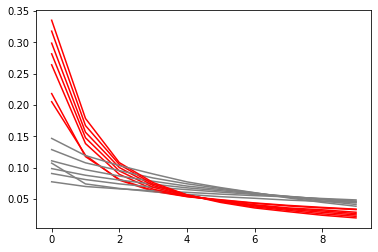

In [102]:
for i in range(var_sil_real_clean.shape[0]):
    plt.plot(var_sil_real_clean[i].mean(axis=0), color='red')
    plt.plot(var_sil_shuf_clean[i].mean(axis=0), color='gray')

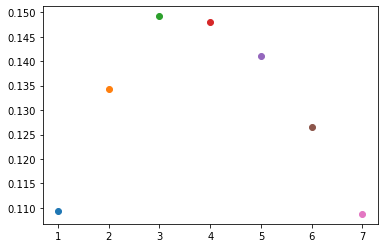

In [116]:
max_comp = 10
for i in range(var_sil_real_clean.shape[0]):
    diff = var_sil_real_clean[i].mean(axis=0)[:max_comp] - var_sil_shuf_clean[i].mean(axis=0)[:max_comp]
    plt.scatter(i+1, diff.sum())

## PCA

In [134]:
# read from file
session = '009266_hippoSIT_2023-04-17_17-04-17'

animal   = session.split('_')[0]
s_path   = os.path.join(source, animal, session)
coh_file = os.path.join(s_path, 'analysis', 'coherence.h5')

with h5py.File(coh_file, 'r') as f:
    corrs_real_BGR = np.array(f['corrs_real_BGR'])
    corrs_shuf_BGR = np.array(f['corrs_shuf_BGR'])
    var_real_BGR = np.array(f['var_real_BGR'])
    var_shuf_BGR = np.array(f['var_shuf_BGR'])
    comp_real_BGR = np.array(f['comp_real_BGR'])

    corrs_real_SIL = np.array(f['corrs_real_SIL'])
    corrs_shuf_SIL = np.array(f['corrs_shuf_SIL'])
    var_real_SIL = np.array(f['var_real_SIL'])
    var_shuf_SIL = np.array(f['var_shuf_SIL'])
    comp_real_SIL = np.array(f['comp_real_SIL'])

In [137]:
var_sil_real = var_real_BGR
var_sil_shuf = var_shuf_BGR

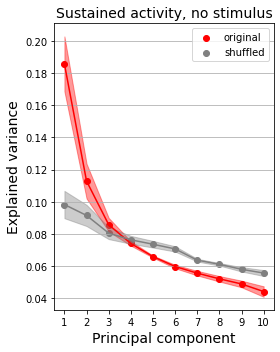

In [138]:
fig, ax = plt.subplots(1, 1, figsize=(4, 5))

x_vals = (np.arange(comp_count) + 1).astype(np.int32)
conf_low_real, conf_high_real = get_conf_intervals(var_sil_real)
conf_low_shuf, conf_high_shuf = get_conf_intervals(var_sil_shuf)
verm = var_sil_real.mean(axis=0)
vesm = var_sil_shuf.mean(axis=0)
sem_real = stats.sem(var_sil_real)
sem_shuf = stats.sem(var_sil_shuf)

ax.plot(x_vals, var_sil_real.mean(axis=0), color='red')
ax.plot(x_vals, var_sil_shuf.mean(axis=0), color='grey')
ax.scatter(x_vals, var_sil_real.mean(axis=0), color='red', label='original')
ax.scatter(x_vals, var_sil_shuf.mean(axis=0), color='grey', label='shuffled')

# sems
ax.fill_between(x_vals, verm - sem_real, verm + sem_real, color='red', alpha=0.4)
ax.fill_between(x_vals, vesm - sem_shuf, vesm + sem_shuf, color='grey', alpha=0.4)

# 5 - 95 conf intervals
#ax.fill_between(x_vals, conf_low_real, conf_high_real, color='red', alpha=0.4)
#ax.fill_between(x_vals, conf_low_shuf, conf_high_shuf, color='grey', alpha=0.4)
#ax.set_ylim(0, 0.15)

ax.grid(axis='y')
ax.set_xticks(x_vals)
ax.set_xticklabels(x_vals, fontsize=10)
ax.set_xlabel('Principal component', fontsize=14)
ax.set_ylabel('Explained variance', fontsize=14)
ax.set_title('Sustained activity, no stimulus', fontsize=14)
ax.legend()

fig.tight_layout()

In [31]:
fig.savefig(os.path.join(rep_path, 'PCA_unit_mx_no_stimulus.png'), dpi=300)

## Pairwise correlations

In [141]:
#corrs_real_flat = np.concatenate([x for x in corrs_real_all])
#corrs_shuf_flat = np.concatenate([x for x in corrs_shuf_all])

corrs_real_flat = np.concatenate([x for x in corrs_real_SIL])
corrs_shuf_flat = np.concatenate([x for x in corrs_shuf_SIL])

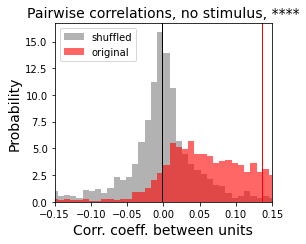

In [142]:
bins_nc = np.linspace(-0.3, 0.3, 71)
#bins_nc = np.linspace(-1, 1, 101)

#idx = 30
#corrs_shuf = corrs_shuf_all[idx]
#corrs_real = corrs_real_all[idx]

corrs_real = corrs_real_flat
corrs_shuf = corrs_shuf_flat

_, pval = stats.mannwhitneyu(corrs_shuf, corrs_real)

fig, ax = plt.subplots(1, 1, figsize=(4, 3.5))
ax.hist(corrs_shuf, bins=bins_nc, density=True, alpha=0.6, color='grey', label='shuffled')
ax.hist(corrs_real, bins=bins_nc, density=True, alpha=0.6, color='red', label='original')
ax.axvline(corrs_shuf.mean(), color='black', lw=1)
ax.axvline(corrs_real.mean(), color='red', lw=1)
ax.set_xlim(-0.15, 0.15)
#ax.set_xlim(-0.5, 0.5)
ax.legend()
ax.set_xlabel("Corr. coeff. between units", fontsize=14)
ax.set_ylabel("Probability", fontsize=14)
ax.set_title('Pairwise correlations, no stimulus, %s' % get_asterisks(pval), fontsize=14)

fig.tight_layout()

In [33]:
fig.savefig(os.path.join(rep_path, 'pairwise_correlations_no_stimulus.png'), dpi=300)

In [28]:
stats.mannwhitneyu(corrs_shuf, corrs_real)

MannwhitneyuResult(statistic=77592301.0, pvalue=0.0)

## Sustained - background

In [50]:
bin_size = 0.125
comp_count = 10  # PCA components
event_id = 1  # BGR only
conditions = {-1: 'NOI', 0: 'SIL', 1: 'BGR', 2: 'TGT'}

var_bgr_real = np.zeros([len(selected), comp_count])
var_bgr_shuf = np.zeros([len(selected), comp_count])
corrs_real_all = []
corrs_shuf_all = []
first_PCs_bgr = []

for i, session in enumerate(selected):
    # read datasets
    animal    = session.split('_')[0]
    s_path    = os.path.join(source, animal, session)
    meta_file = os.path.join(s_path, 'meta.h5')
    unit_file = os.path.join(s_path, 'units.h5')
    psth_file = os.path.join(s_path, 'analysis', 'psth_micro.h5')

    with h5py.File(meta_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])
        tgt_mx = np.array(f['processed']['target_matrix'])
        sound_events = np.array(f['processed']['sound_events'])
        cfg = json.loads(f['processed'].attrs['parameters'])
    
    latency  = cfg['sound']['latency']  # seconds
    bins_per_event = int(latency / bin_size)
    electrodes = nMAP_electrodes[animal]
    bins_ev, unit_mx_real = unit_activity_matrix(meta_file, unit_file, electrodes, bin_size=bin_size)
    bins_ev, unit_mx_shuf = unit_activity_matrix(meta_file, unit_file, electrodes, bin_size=bin_size, shuffle=True)

    if unit_mx_real.shape[0] < comp_count:
        continue
        
    # which sound pulses to consider
    idxs_cond = np.where(sound_events[:, 1] == event_id)[0]  # event sampling

    su_mx_real = unit_mx_real[:, 1::2]
    su_mx_shuf = unit_mx_shuf[:, 1::2]

    # z-score
    for j in range(len(su_mx_real)):
        su_mx_real[j] = stats.zscore(su_mx_real[j])
    for j in range(len(su_mx_shuf)):
        su_mx_shuf[j] = stats.zscore(su_mx_shuf[j])
    
    pca_real = decomposition.PCA(n_components=comp_count)
    X_real   = pca_real.fit_transform(su_mx_real.T)
    pca_shuf = decomposition.PCA(n_components=comp_count)
    X_shuf   = pca_shuf.fit_transform(su_mx_shuf.T)
    
    var_bgr_real[i] = pca_real.explained_variance_ratio_
    var_bgr_shuf[i] = pca_shuf.explained_variance_ratio_
    
    first_PCs_bgr.append(X_real[0])
    
    print('\rSession %s done' % session[-19:-6], end='')
    
not_enough = len([x for x in var_bgr_real if (x == 0).all()])
print("\nEnough units: %d, not enough: %d" % (len(selected) - not_enough, not_enough))

Session 2024-01-15_14 done
Enough units: 40, not enough: 14


In [48]:
# remove rows with not enough units
var_bgr_real = var_bgr_real[~np.all(var_bgr_real == 0, axis=1)]
var_bgr_shuf = var_bgr_shuf[~np.all(var_bgr_shuf == 0, axis=1)]

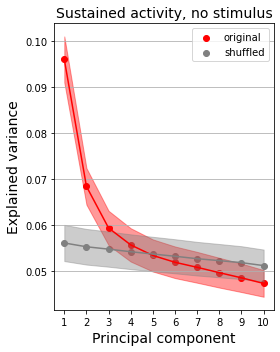

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(4, 5))

x_vals = (np.arange(comp_count) + 1).astype(np.int32)
conf_low_real, conf_high_real = get_conf_intervals(var_bgr_real)
conf_low_shuf, conf_high_shuf = get_conf_intervals(var_bgr_shuf)
verm = var_bgr_real.mean(axis=0)
vesm = var_bgr_shuf.mean(axis=0)
sem_real = stats.sem(var_bgr_real)
sem_shuf = stats.sem(var_bgr_shuf)

ax.plot(x_vals, var_bgr_real.mean(axis=0), color='red')
ax.plot(x_vals, var_bgr_shuf.mean(axis=0), color='grey')
ax.scatter(x_vals, var_bgr_real.mean(axis=0), color='red', label='original')
ax.scatter(x_vals, var_bgr_shuf.mean(axis=0), color='grey', label='shuffled')

# sems
ax.fill_between(x_vals, verm - sem_real, verm + sem_real, color='red', alpha=0.4)
ax.fill_between(x_vals, vesm - sem_shuf, vesm + sem_shuf, color='grey', alpha=0.4)

# 5 - 95 conf intervals
#ax.fill_between(x_vals, conf_low_real, conf_high_real, color='red', alpha=0.4)
#ax.fill_between(x_vals, conf_low_shuf, conf_high_shuf, color='grey', alpha=0.4)
#ax.set_ylim(0, 0.15)

ax.grid(axis='y')
ax.set_xticks(x_vals)
ax.set_xticklabels(x_vals, fontsize=10)
ax.set_xlabel('Principal component', fontsize=14)
ax.set_ylabel('Explained variance', fontsize=14)
ax.set_title('Sustained activity, no stimulus', fontsize=14)
ax.legend()

fig.tight_layout()